In [1]:
import os
import pandas as pd

def create_image_dataframe(base_dir='pictures'):
    data = []

    for country in os.listdir(base_dir):
        country_path = os.path.join(base_dir, country)
        if not os.path.isdir(country_path):
            continue

        for prompt_type in os.listdir(country_path):
            prompt_path = os.path.join(country_path, prompt_type)
            if not os.path.isdir(prompt_path):
                continue

            # Normalize prompt name: 'Prompt - China' -> 'China' or 'English'
            if 'English' in prompt_type:
                prompt = 'English'
            else:
                prompt = country  # The prompt is in the country's language

            for model in os.listdir(prompt_path):
                model_path = os.path.join(prompt_path, model)
                if not os.path.isdir(model_path):
                    continue

                for img_file in os.listdir(model_path):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.webp')):
                        image_path = os.path.join(model_path, img_file)
                        data.append({
                            'country': country,
                            'prompt': prompt,
                            'model': model,
                            'image_path': image_path
                        })

    df = pd.DataFrame(data)
    return df

In [2]:
import torch
from PIL import Image
from torchvision import transforms
import open_clip

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
def add_clip_embeddings(df, device):
    model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')
    model = model.to(device)
    model.eval()

    clip_embeddings = []

    for path in df['image_path']:
        try:
            image = preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
            with torch.no_grad():
                embedding = model.encode_image(image).squeeze().cpu().numpy()
        except Exception as e:
            print(f"Error processing {path}: {e}")
            embedding = None
        clip_embeddings.append(embedding)

    df['clip'] = clip_embeddings
    return df

In [3]:
df = create_image_dataframe("/Users/traopia/Documents/GitHub/GenAI-political-portraits/pictures")
df = add_clip_embeddings(df, device)
df.to_json("data_genai.json",orient = "records" , lines = True)

/Users/traopia/miniconda3/envs/genai-political/lib/python3.13/site-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


In [4]:
import numpy as np
import torch.nn.functional as F

def compute_country_predictions(df, device):
    # Load CLIP model
    model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')
    tokenizer = open_clip.get_tokenizer('ViT-B-32')
    model = model.to(device)
    model.eval()

    # Get unique country names
    countries = sorted(df['country'].unique())
    #countries.append("English")
    country_texts = [f"{c}" for c in countries]  # Add context if you like

    # Encode country names as text embeddings
    with torch.no_grad():
        tokenized = tokenizer(country_texts).to(device)
        text_features = model.encode_text(tokenized)
        text_features = F.normalize(text_features, dim=-1)  # L2-normalize

    # Convert image embeddings to tensor and normalize
    image_features = torch.tensor(np.stack(df['clip'].values)).to(device)
    image_features = F.normalize(image_features, dim=-1)

    # Compute cosine similarity (dot product after normalization)
    similarities = image_features @ text_features.T  # shape: [num_images, num_countries]

    # Apply softmax to get probabilities
    probs = F.softmax(similarities, dim=1).cpu().numpy()

    # Get predictions and top match
    predicted_idxs = np.argmax(probs, axis=1)
    predicted_countries = [countries[i] for i in predicted_idxs]

    # Add to dataframe
    df['predicted_country'] = predicted_countries
    df['country_correct'] = df['predicted_country'] == df['country']

    return df, probs

In [5]:
def compute_politician_prediction(df, device=device):
    # Load CLIP model
    model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')
    tokenizer = open_clip.get_tokenizer('ViT-B-32')
    model = model.to(device)
    model.eval()

    # Define class texts
    class_names = ["Photo of a politician", "Other"]
    
    # Encode the class texts
    with torch.no_grad():
        text_tokens = tokenizer(class_names).to(device)
        text_features = model.encode_text(text_tokens)
        text_features = F.normalize(text_features, dim=-1)  # shape: [2, d]

    # Prepare image features
    image_features = torch.tensor(np.stack(df['clip'].values)).to(device)
    image_features = F.normalize(image_features, dim=-1)

    # Compute similarity scores (dot product)
    logits = image_features @ text_features.T  # shape: [N_images, 2]

    # Apply softmax across classes
    probs = F.softmax(logits, dim=-1).cpu().numpy()

    # Get predictions
    pred_indices = np.argmax(probs, axis=1)
    predicted_labels = [class_names[i] for i in pred_indices]

    # Store results
    # df['politician_prob'] = probs[:, 0]
    # df['other_prob'] = probs[:, 1]
    df['predicted_label'] = predicted_labels
    df['politician'] = df['predicted_label'] == "Photo of a politician"

    return df

In [ ]:
df, probs = compute_country_predictions(df, device)
df = compute_politician_prediction(df)

accuracy = df['country_correct'].mean()
print(f"Prediction accuracy: {accuracy:.2%}")

/Users/traopia/miniconda3/envs/genai-political/lib/python3.13/site-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


Prediction accuracy: 76.74%


In [ ]:
df[df["politician"]==False]
df[df["country_correct"]==False]

In [9]:
def compute_accuracy_tables(df):
    acc_by_country = df.groupby('country')[['country_correct', 'politician']].mean().reset_index()
    acc_by_model = df.groupby('model')[['country_correct', 'politician']].mean().reset_index()
    acc_by_prompt = df.groupby('prompt')[['country_correct', 'politician']].mean().reset_index()
    acc_by_all = df.groupby(['country', 'prompt', 'model'])[['country_correct', 'politician']].mean().reset_index()
    
    return acc_by_country, acc_by_model, acc_by_prompt, acc_by_all

acc_by_country, acc_by_model, acc_by_prompt, acc_by_all = compute_accuracy_tables(df)

In [10]:
acc_by_all.sort_values(by="country_correct")

,country,prompt,model,country_correct,politician
10,Italy,Italy,OpenAI,0.083333,1.000000
1,China,China,OpenAI,0.090909,1.000000
9,Italy,Italy,Midjourney,0.250000,1.000000
11,Italy,Italy,Stable Diffusion,0.500000,1.000000
15,Netherlands,Netherlands,Midjourney,0.666667,0.750000
6,Italy,English,Midjourney,0.666667,1.000000
2,China,China,Stable Diffusion,0.833333,0.000000
16,Netherlands,Netherlands,OpenAI,0.833333,1.000000
8,Italy,English,Stable Diffusion,0.916667,1.000000
17,Netherlands,Netherlands,Stable Diffusion,0.916667,0.833333


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap

def plot_embedding_space(df, method='umap', n_components=2):
    image_embs = np.stack(df['clip'].values)
    country_labels = df['country'].values
    model_labels = df['model'].values
    correct_flags = df['country_correct'].values

    reducer = {
        'umap': umap.UMAP(n_components=n_components, random_state=42),
        'tsne': TSNE(n_components=n_components, random_state=42),
        'pca': PCA(n_components=n_components)
    }[method]

    embedding_2d = reducer.fit_transform(image_embs)

    df_plot = df.copy()
    df_plot['x'] = embedding_2d[:, 0]
    df_plot['y'] = embedding_2d[:, 1]

    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        data=df_plot,
        x='x', y='y',
        hue='country',
        style='model',
        palette='tab10',
        alpha=0.7,
        markers=True,
        s=80,
        edgecolor=None
    )

    # Highlight mistakes
    wrongs = df_plot[~df_plot['country_correct']]
    plt.scatter(wrongs['x'], wrongs['y'], facecolors='none', edgecolors='red', linewidths=1.5, label='Mistakes')

    plt.title(f'{method.upper()} Projection of CLIP Embeddings')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

/Users/traopia/miniconda3/envs/genai-political/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/traopia/miniconda3/envs/genai-political/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


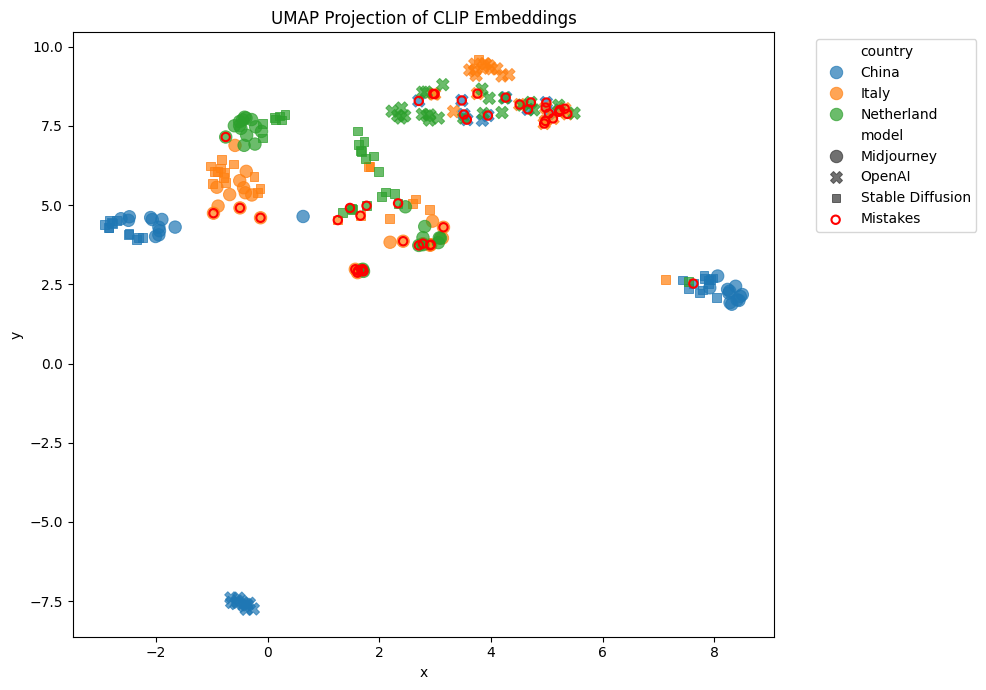

In [41]:
plot_embedding_space(df, method='umap')

In [23]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

def reduce_embeddings(df, method='umap'):
    image_embs = np.stack(df['clip'].values)
    reducer = {
        'umap': umap.UMAP(n_components=2, random_state=42),
        'tsne': TSNE(n_components=2, random_state=42),
        'pca': PCA(n_components=2)
    }[method]

    reduced = reducer.fit_transform(image_embs)
    df['x'] = reduced[:, 0]
    df['y'] = reduced[:, 1]
    return df

In [24]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import numpy as np

def plot_embeddings_with_images_matplotlib(df, figsize=(20, 15), dot_size=100):
    fig, ax = plt.subplots(figsize=figsize)

    for idx, row in df.iterrows():
        x, y = row['x'], row['y']
        img_path = row['image_path']
        country_correct = row.get('country_correct', True)
        politician_correct = row.get('politician', True)

        # Load and resize image
        try:
            img = Image.open(img_path)
            img.thumbnail((50, 50))
            imagebox = OffsetImage(img, zoom=1)
        except Exception as e:
            print(f"Failed to load {img_path}: {e}")
            continue

        # Draw thumbnail
        ab = AnnotationBbox(
            imagebox, (x, y),
            frameon=True,
            bboxprops=dict(
                edgecolor='red' if not country_correct or not politician_correct else 'green',
                linewidth=2
            )
        )
        ax.add_artist(ab)

    # Optional: Overlay points with class color
    scatter = ax.scatter(df['x'], df['y'],
                         c=df['country'].astype('category').cat.codes,
                         cmap='tab20', alpha=0.1, s=dot_size)

    ax.set_title('Embedding Space with Image Thumbnails', fontsize=16)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

/Users/traopia/miniconda3/envs/genai-political/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/traopia/miniconda3/envs/genai-political/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



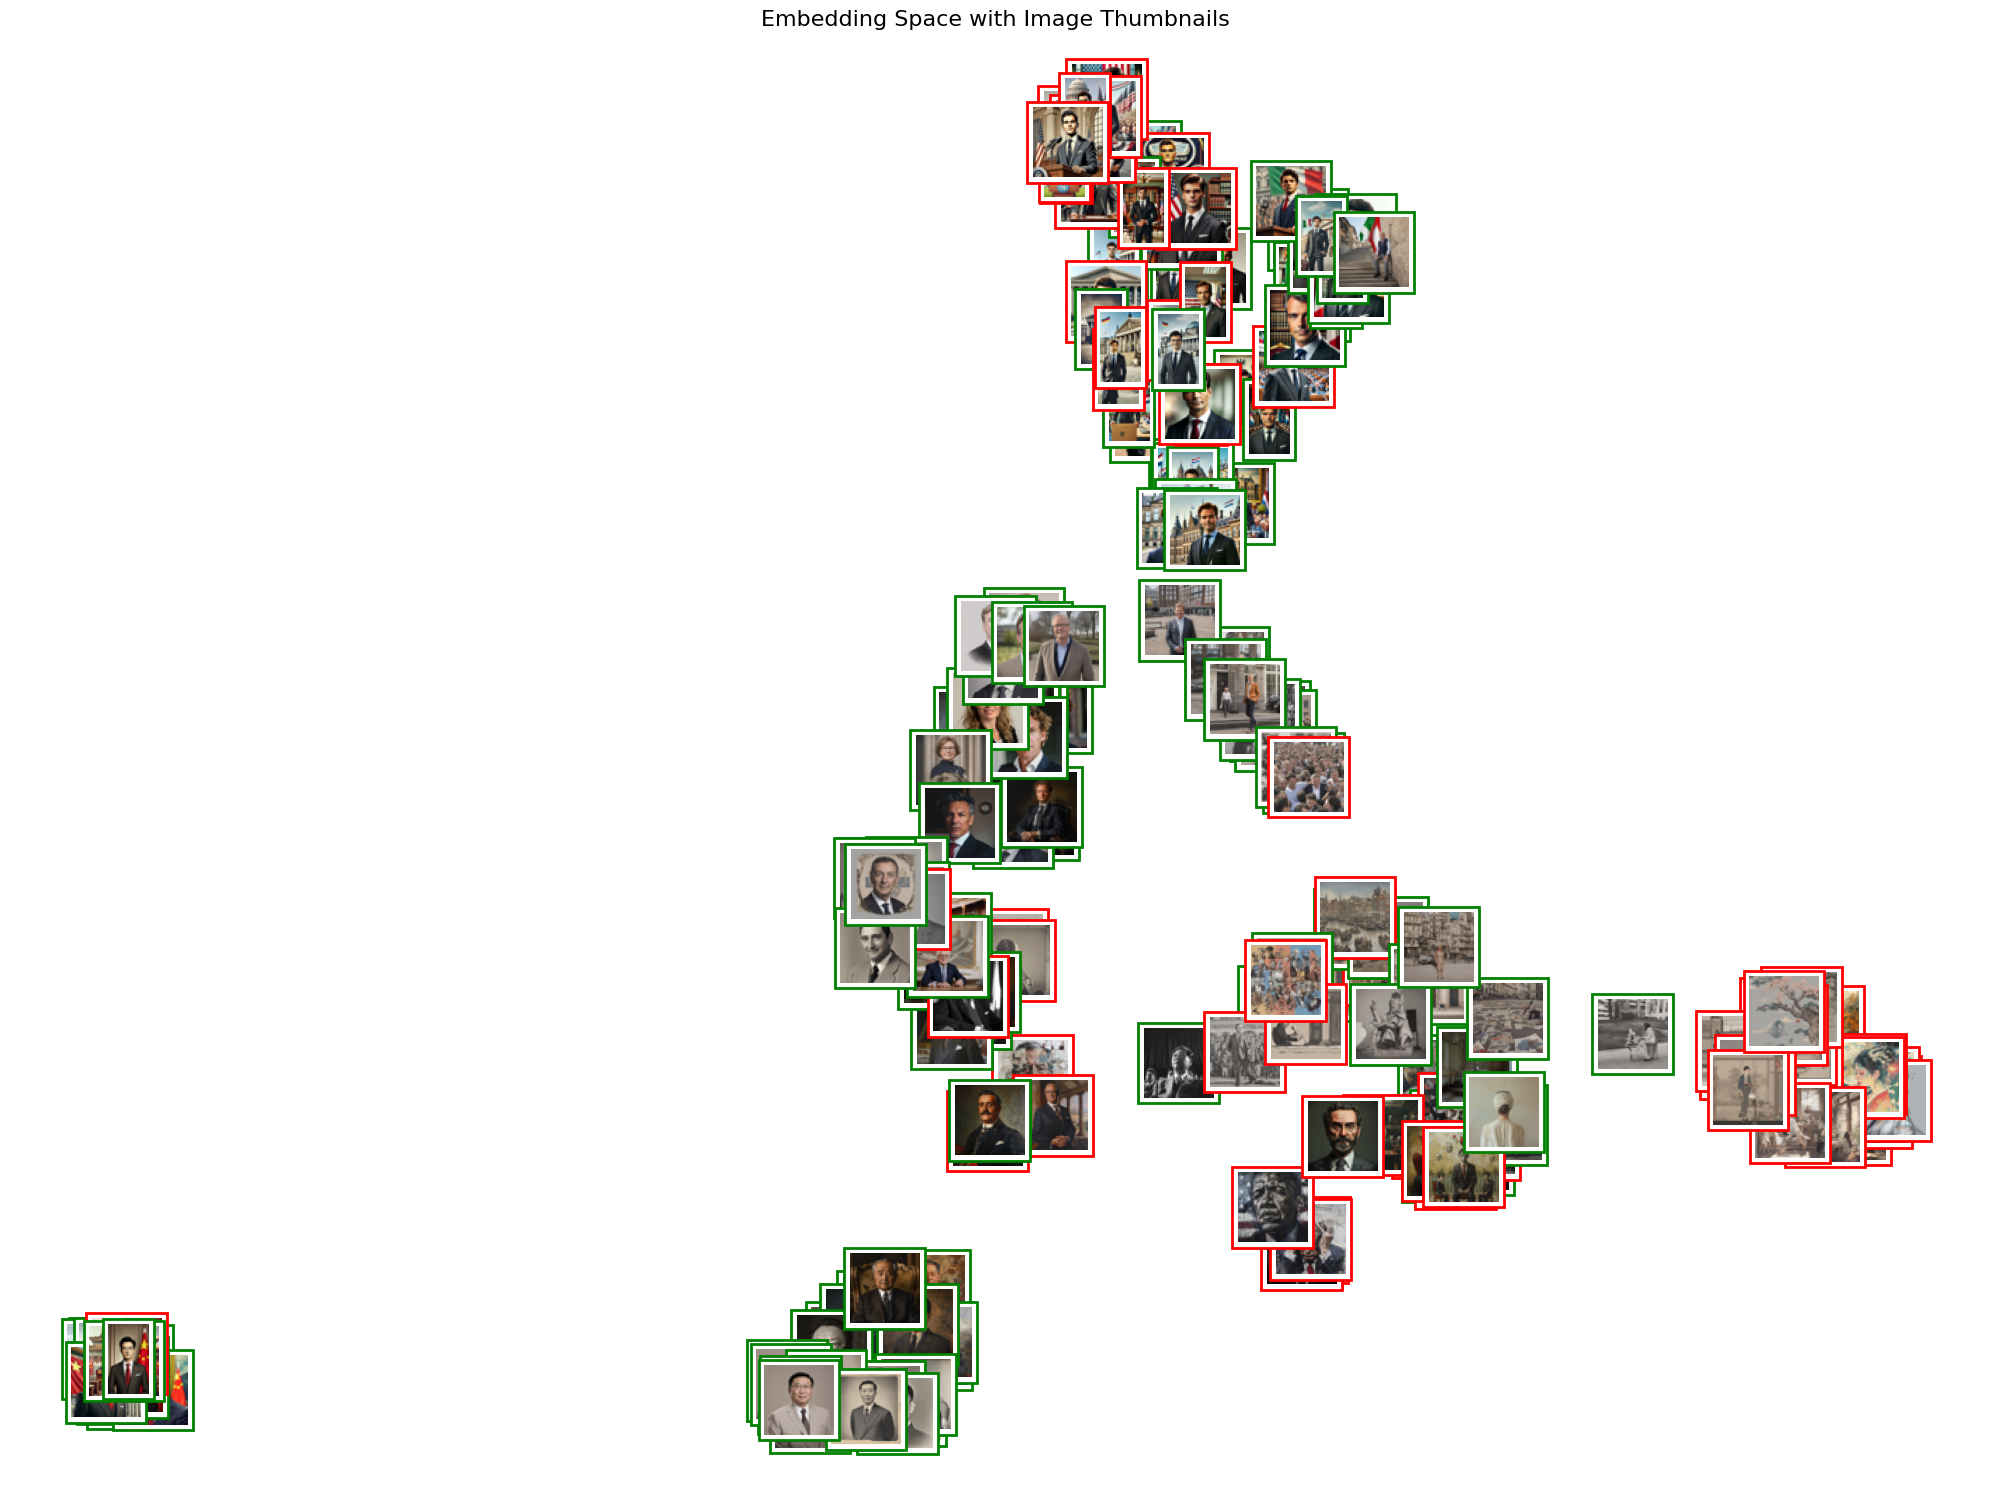

In [25]:
df = reduce_embeddings(df, method='umap')  # if not already done
plot_embeddings_with_images_matplotlib(df)

In [16]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import numpy as np
import matplotlib.patches as mpatches

def plot_embeddings_with_double_borders(df, figsize=(20, 15), dot_size=100):
    fig, ax = plt.subplots(figsize=figsize)

    for _, row in df.iterrows():
        x, y = row['x'], row['y']
        img_path = row['image_path']
        country_correct = row.get('country_correct', True)
        politician_correct = row.get('politician', True)

        # Define colors
        inner_color = 'green' if country_correct else 'red'
        outer_color = 'blue' if politician_correct else 'orange'

        try:
            img = Image.open(img_path)
            img.thumbnail((50, 50))
            imagebox = OffsetImage(img, zoom=1)

            # Outer box (politician) - slightly bigger
            outer_ab = AnnotationBbox(
                imagebox, (x, y),
                bboxprops=dict(edgecolor=outer_color, linewidth=1.5),
                frameon=True
            )
            ax.add_artist(outer_ab)

            # Inner box (country) - on top, slightly smaller image
            inner_img = img.copy()
            inner_img.thumbnail((40, 40))
            inner_imagebox = OffsetImage(inner_img, zoom=1)
            inner_ab = AnnotationBbox(
                inner_imagebox, (x, y),
                bboxprops=dict(edgecolor=inner_color, linewidth=1.5),
                frameon=True
            )
            ax.add_artist(inner_ab)

        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            continue

    # Optional: base scatter just for layout reference
    ax.scatter(df['x'], df['y'],
               c=df['country'].astype('category').cat.codes,
               cmap='tab20', alpha=0.05, s=dot_size)

    # Legend
    legend_elements = [
        mpatches.Patch(color='green', label='Country correct'),
        mpatches.Patch(color='red', label='Country wrong'),
        mpatches.Patch(color='blue', label='Politician correct'),
        mpatches.Patch(color='orange', label='Politician wrong'),
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=12)

    ax.set_title('UMAP of CLIP Embedding Space – Highlighting Country & Politician Accuracy', fontsize=16)
    #ax.axis('off')
    plt.tight_layout()
    plt.show()

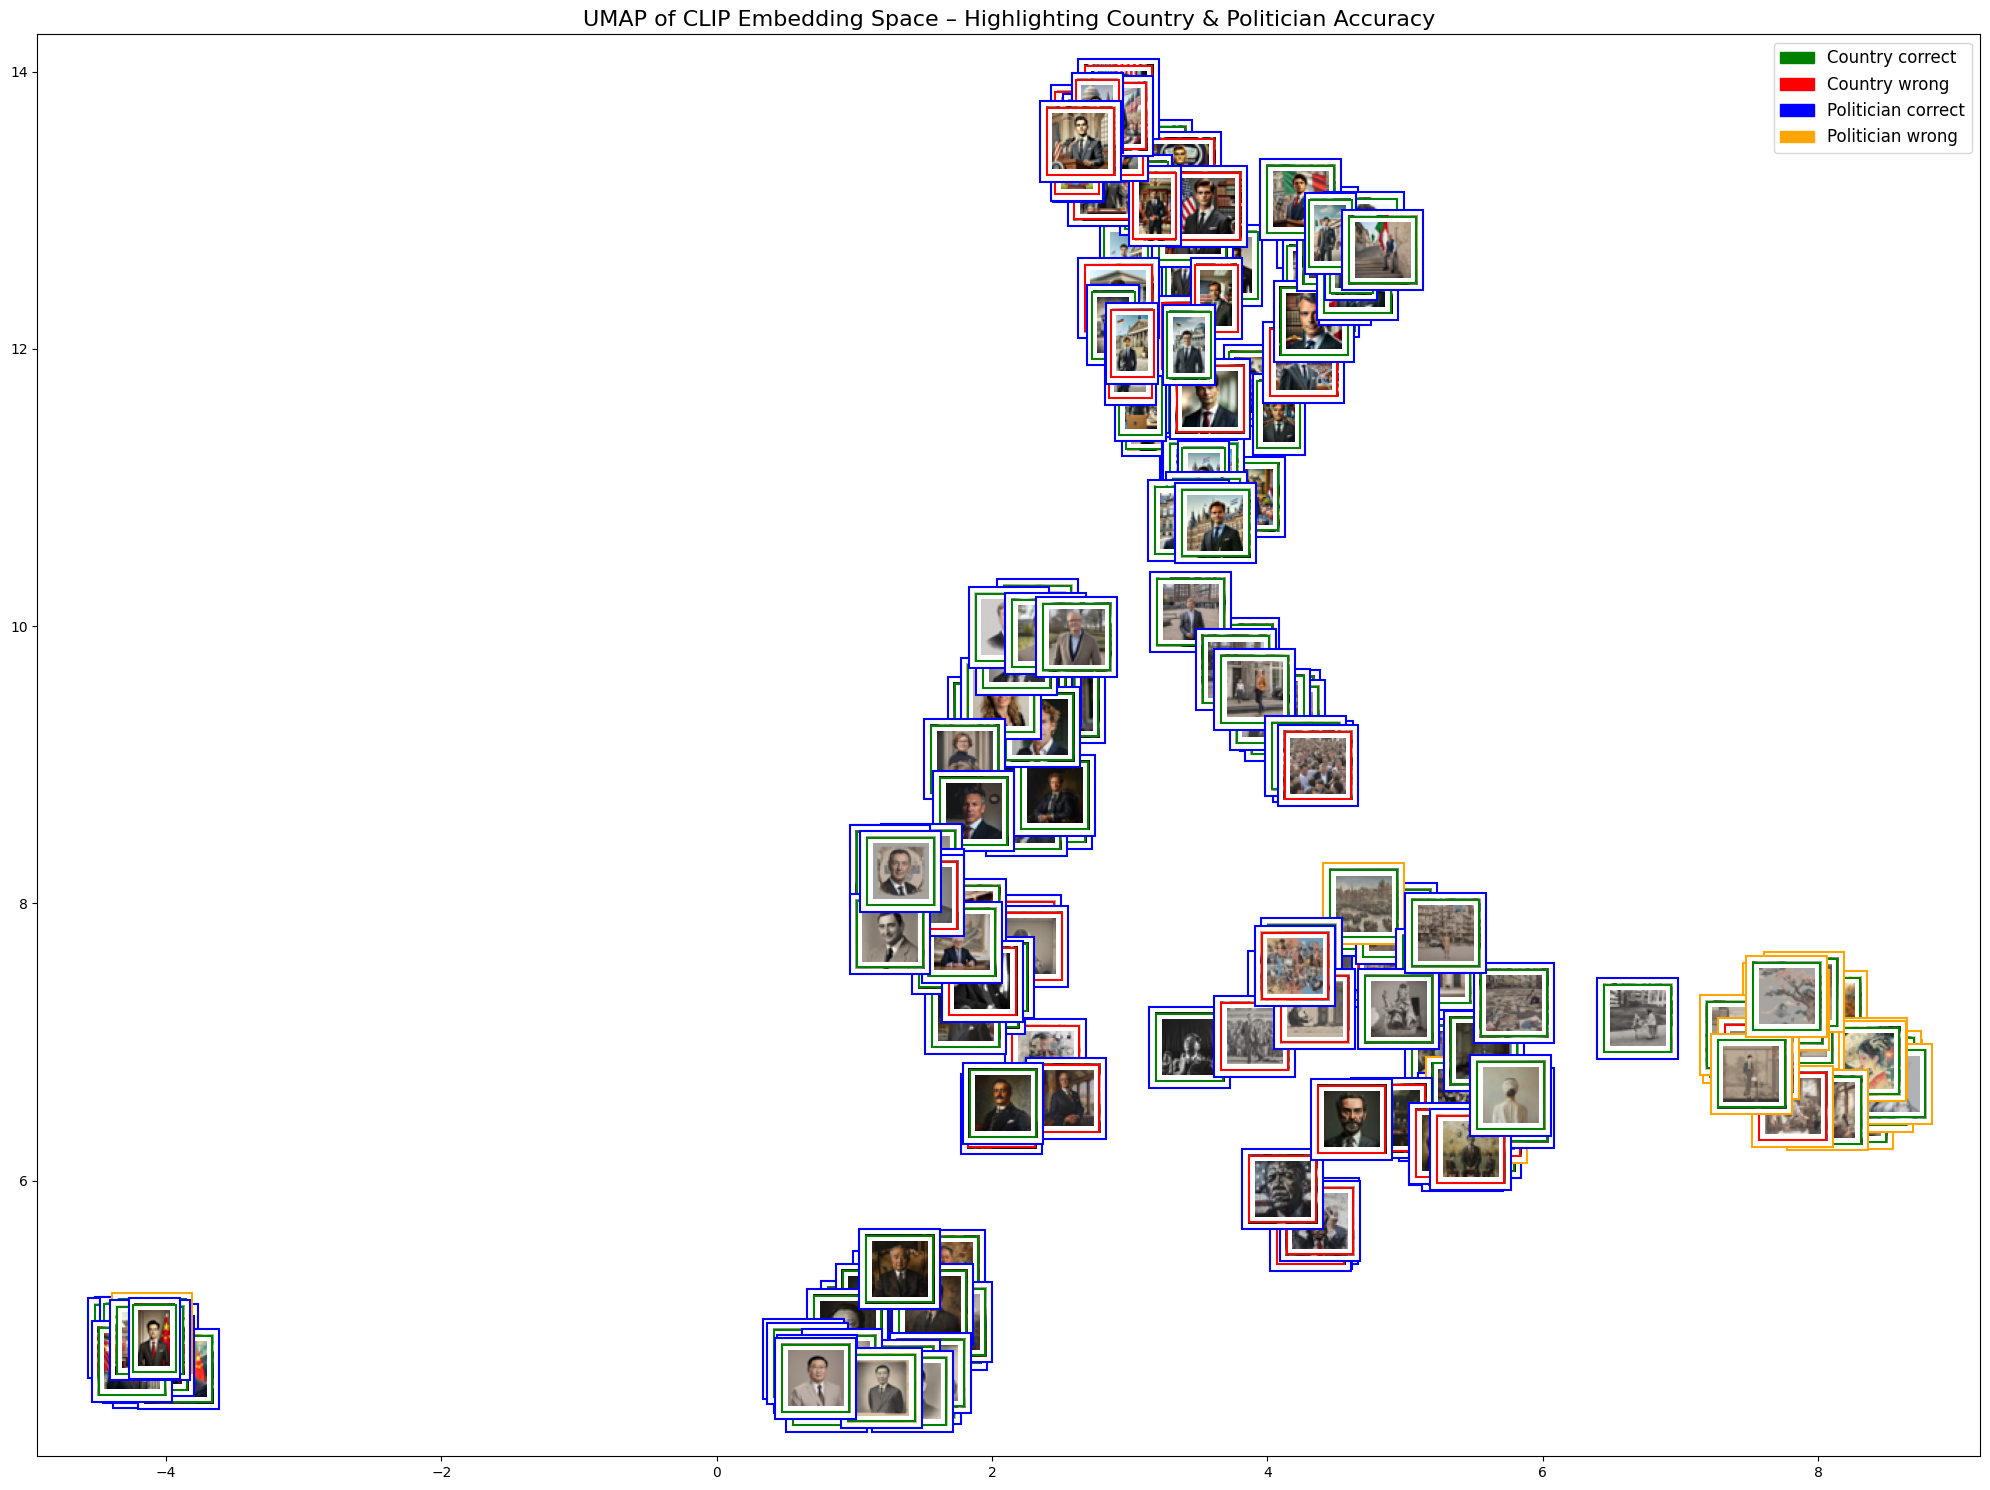

In [26]:
#df = reduce_embeddings(df, method='umap')
plot_embeddings_with_double_borders(df)

In [18]:
from sklearn.metrics import silhouette_score
import numpy as np

X = np.vstack(df["clip"].values)  # shape (n_samples, n_features)

# For each grouping, encode labels numerically
from sklearn.preprocessing import LabelEncoder

def silhouette_by_label(col_name):
    labels = LabelEncoder().fit_transform(df[col_name])
    score = silhouette_score(X, labels, metric='cosine')  # cosine distance fits CLIP
    print(f"Silhouette score for {col_name}: {score:.4f}")
    return score

silhouette_by_label("country")
silhouette_by_label("prompt")
silhouette_by_label("model")
df["combo_label"] = df["country"] + "_" + df["prompt"] + "_" + df["model"]
silhouette_by_label("combo_label")


Silhouette score for country: 0.0835
Silhouette score for prompt: 0.0705
Silhouette score for model: 0.1422
Silhouette score for combo_label: 0.1303


np.float32(0.13033864)

In [21]:
df

,country,prompt,model,image_path,clip,predicted_country,country_correct,predicted_label,politician,x,y,combo_label,umap_x,umap_y
0,Netherlands,Netherlands,Midjourney,/Users/traopia/Documents/GitHub/GenAI-politica...,"[-0.005080506, 0.052672148, -0.18440036, 0.172...",China,False,Photo of a politician,True,5.251563,6.430867,Netherlands_Netherlands_Midjourney,0.197387,7.901411
1,Netherlands,Netherlands,Midjourney,/Users/traopia/Documents/GitHub/GenAI-politica...,"[0.044155754, -0.06097264, -0.09742644, -0.015...",Netherlands,True,Other,False,5.029472,7.542783,Netherlands_Netherlands_Midjourney,-0.366271,7.200957
2,Netherlands,Netherlands,Midjourney,/Users/traopia/Documents/GitHub/GenAI-politica...,"[-0.02756001, 0.34988424, -0.1292944, -0.37968...",China,False,Photo of a politician,True,4.363075,5.686977,Netherlands_Netherlands_Midjourney,1.449242,7.661301
3,Netherlands,Netherlands,Midjourney,/Users/traopia/Documents/GitHub/GenAI-politica...,"[0.4343934, -0.17608616, -0.051046267, 0.40240...",Netherlands,True,Photo of a politician,True,5.550541,6.309995,Netherlands_Netherlands_Midjourney,0.083856,8.023932
4,Netherlands,Netherlands,Midjourney,/Users/traopia/Documents/GitHub/GenAI-politica...,"[0.2253407, 0.31527764, -0.17473158, -0.157876...",Netherlands,True,Photo of a politician,True,5.295080,6.874056,Netherlands_Netherlands_Midjourney,-0.106689,7.484642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,Italy,English,Stable Diffusion,/Users/traopia/Documents/GitHub/GenAI-politica...,"[0.35145223, -0.48344654, -0.4428285, -0.32376...",Italy,True,Photo of a politician,True,1.259484,8.277591,Italy_English_Stable Diffusion,3.078631,4.349996
211,Italy,English,Stable Diffusion,/Users/traopia/Documents/GitHub/GenAI-politica...,"[-0.05045665, -0.26296282, 0.008686036, 0.0811...",Italy,True,Photo of a politician,True,1.781585,7.718298,Italy_English_Stable Diffusion,2.283606,4.650031
212,Italy,English,Stable Diffusion,/Users/traopia/Documents/GitHub/GenAI-politica...,"[0.12027054, -0.28125915, -0.22406606, -0.2802...",China,False,Photo of a politician,True,1.506765,8.057782,Italy_English_Stable Diffusion,2.989812,4.475485
213,Italy,English,Stable Diffusion,/Users/traopia/Documents/GitHub/GenAI-politica...,"[0.15639833, -0.07780737, -0.5419984, 0.094541...",Italy,True,Photo of a politician,True,1.259794,7.780065,Italy_English_Stable Diffusion,3.136078,4.890704


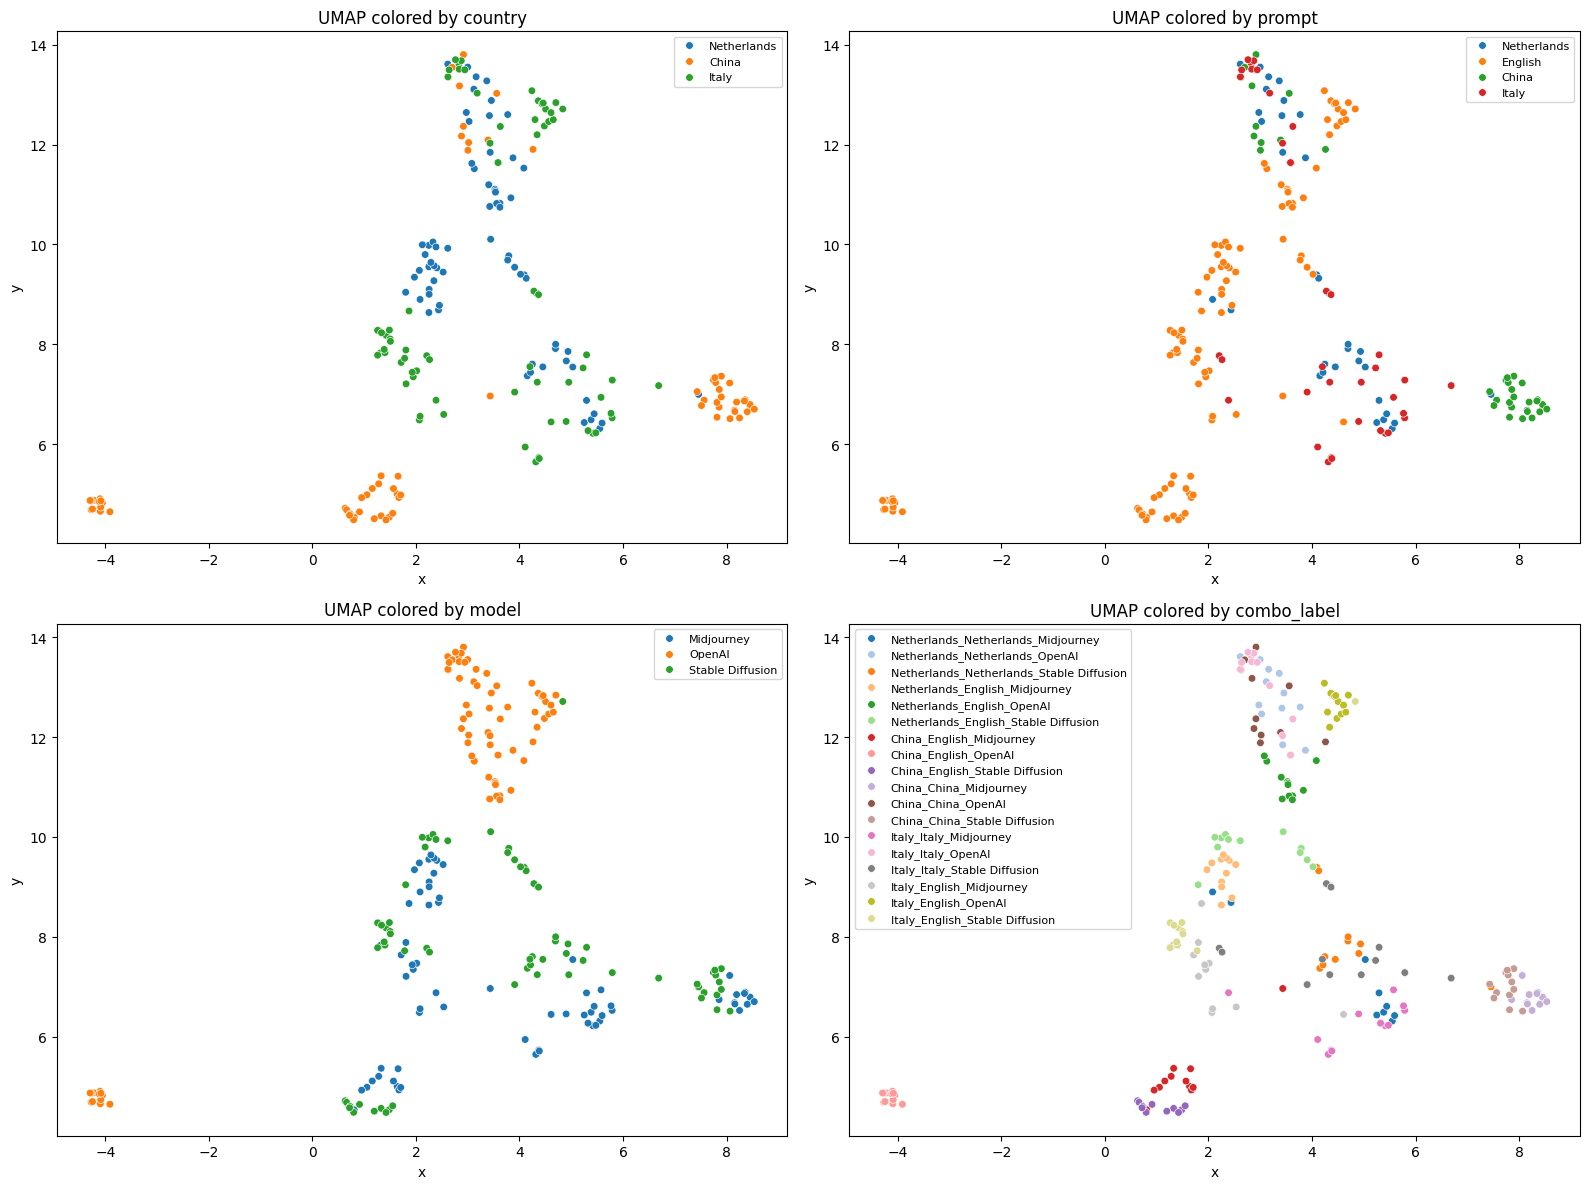

In [27]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# umap_model = umap.UMAP(metric="cosine", random_state=42)
# proj = umap_model.fit_transform(X)
# df["umap_x"], df["umap_y"] = proj[:, 0], proj[:, 1]

# Visualize by country, prompt, model, or combo
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
for ax, col in zip(axes.flat, ["country", "prompt", "model", "combo_label"]):
    if col == "combo_label":
        sns.scatterplot(data=df, x="x", y="y", hue=col, ax=ax, palette="tab20", s=30)
    else:
        sns.scatterplot(data=df, x="x", y="y", hue=col, ax=ax, palette="tab10", s=30)
    ax.set_title(f"UMAP colored by {col}")
    ax.legend(loc="best", fontsize=8)

plt.tight_layout()
plt.show()

In [28]:
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

def silhouette_scores_per_value(df, label_col, embedding_col="clip"):
    X = np.vstack(df[embedding_col].values)
    le = LabelEncoder()
    labels = le.fit_transform(df[label_col])
    label_names = le.inverse_transform(np.unique(labels))

    # Get silhouette scores for each sample
    sample_silhouette = silhouette_samples(X, labels, metric='cosine')

    # Add to dataframe for aggregation
    df_sil = df.copy()
    df_sil["silhouette"] = sample_silhouette
    avg_scores = df_sil.groupby(label_col)["silhouette"].mean().sort_values(ascending=False)

    print(f"\n📊 Average silhouette scores per '{label_col}' value:\n")
    print(avg_scores)

    return avg_scores, df_sil

In [29]:
# Score per country
silhouette_scores_per_value(df, "country")

# Score per prompt
silhouette_scores_per_value(df, "prompt")

# Score per model
silhouette_scores_per_value(df, "model")

# Score per combo of all three
df["combo_label"] = df["country"] + "_" + df["prompt"] + "_" + df["model"]
silhouette_scores_per_value(df, "combo_label")


📊 Average silhouette scores per 'country' value:

country
China          0.134307
Italy          0.073296
Netherlands    0.043675
Name: silhouette, dtype: float32

📊 Average silhouette scores per 'prompt' value:

prompt
China          0.141555
English        0.100172
Italy          0.030019
Netherlands   -0.047269
Name: silhouette, dtype: float32

📊 Average silhouette scores per 'model' value:

model
OpenAI              0.355552
Midjourney          0.056796
Stable Diffusion    0.017306
Name: silhouette, dtype: float32

📊 Average silhouette scores per 'combo_label' value:

combo_label
China_English_OpenAI                        0.494738
China_English_Stable Diffusion              0.403109
Italy_English_OpenAI                        0.337727
Netherlands_English_OpenAI                  0.256935
China_China_Midjourney                      0.248037
Netherlands_English_Midjourney              0.246562
Italy_English_Stable Diffusion              0.195369
China_China_Stable Diffusion         

(combo_label
 China_English_OpenAI                        0.494738
 China_English_Stable Diffusion              0.403109
 Italy_English_OpenAI                        0.337727
 Netherlands_English_OpenAI                  0.256935
 China_China_Midjourney                      0.248037
 Netherlands_English_Midjourney              0.246562
 Italy_English_Stable Diffusion              0.195369
 China_China_Stable Diffusion                0.146874
 Italy_Italy_Midjourney                      0.085855
 China_English_Midjourney                    0.059807
 Netherlands_English_Stable Diffusion        0.049832
 Netherlands_Netherlands_Stable Diffusion    0.015023
 China_China_OpenAI                          0.009647
 Italy_Italy_OpenAI                         -0.008481
 Italy_Italy_Stable Diffusion               -0.010775
 Italy_English_Midjourney                   -0.016537
 Netherlands_Netherlands_OpenAI             -0.080281
 Netherlands_Netherlands_Midjourney         -0.097402
 Name: silhouet